# Imports

---

In [47]:
import cv2
import numpy as np
from common_functions import *
from skimage.filters import threshold_minimum,threshold_otsu
from skimage.exposure import equalize_hist
from scipy.ndimage import binary_erosion,binary_closing,binary_opening,binary_dilation
from skimage import exposure
from skimage.measure import find_contours
from skimage.draw import rectangle


# Utils
---

In [48]:


def Erode(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Fit=np.all(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Fit
    return Final

def Dilate(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Hit=np.any(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Hit
    return Final 
def custom_erosion (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_erosion = np.zeros(image.shape)

    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_erosion[y,x] = np.all(multiplied_img == 1) 
    return out_image_erosion 


def custom_dilation (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_dilation = np.zeros(image.shape)
    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_dilation[y,x] = np.any(multiplied_img == 1) 
    return out_image_dilation
def Gamma_correction(img,gamma):
    img = img / img.max()
    img = img* 255
    img = img.astype(np.uint8)
    img = exposure.adjust_gamma(img, gamma)
    return img

def houghTransform(img):
    orgimg=img.copy()
    cdst = orgimg.copy()
    cdstP = np.copy(cdst)
    
    lines = cv2.HoughLines(orgimg, 1, np.pi / 180, 150, None, 0, 0)
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cdst, pt1, pt2, (255,255,255), 2, cv2.LINE_AA)
    
    
    linesP = cv2.HoughLinesP(orgimg, 1, np.pi / 180, 50, None, 50, 60)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255,255,255), 2, cv2.LINE_AA)
    
    return cdstP

## `load_and_preprocess_image`
### Description
Loads the image, converts it to grayscale, and applies gamma correction.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`image`** *(ndarray)*: Original image.
- **`gray`** *(ndarray)*: Grayscale version of the image.
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

---


In [49]:
def load_and_preprocess_image(image_path):
    """Loads the image, converts it to grayscale, and applies gamma correction."""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = Gamma_correction(gray, 2.2)
    return image, gray, gray_image

## `reduce_noise`
### Description
Applies noise reduction techniques to the grayscale image.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`blurred`** *(ndarray)*: Noise-reduced grayscale image.

---


In [50]:
def reduce_noise(gray_image):
    """Applies noise reduction techniques to the grayscale image."""
    blurred = cv2.bilateralFilter(gray_image, 80, 50, 5)
    blurred = cv2.GaussianBlur(blurred, (11, 11), 0)
    return blurred


## `threshold_and_edge_detection`
### Description
Applies thresholding and edge detection to preprocess the image for contour detection.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`edges`** *(ndarray)*: Image with edges highlighted after thresholding and dilation.

---

In [51]:

def threshold_and_edge_detection(gray_image):
    """Applies thresholding and edge detection to preprocess the image for contour detection."""
    threshold = threshold_minimum(gray_image)
    mask = gray_image > threshold
    binary_image = np.zeros(gray_image.shape)
    binary_image[mask] = 255
    binary_image = binary_image.astype(np.uint8)
    edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
    return Dilate(edges, 5)

## `filter_reciept_contours`
### Description
Filters contours to find a rectangular contour with 4 corners and a large area.

### Parameters
- **`contours`** *(list)*: List of contours detected in the image.

### Returns
- **`rectangular_contours`** *(list)*: Contours that are rectangular.
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept with the largest area.

---


In [52]:

def filter_reciept_contours(contours):
    """Filters contours to find a rectangular contour with 4 corners and a large area."""
    rectangular_contours = []
    max_area = 0
    reciept_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 30000:
            peri = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
            #show me the contours on the image
            if area > max_area and len(approx_polygon) == 4:
                rectangular_contours.append(approx_polygon)
                reciept_contour = approx_polygon
                max_area = area
    return rectangular_contours, reciept_contour

In [62]:

def process_image_iteration(preProcessedImage, edges, iterations):
    """Processes the image for a given iteration using various transformations."""
    #if iterations == 0:
     #3   return edges
    #elif iterations == 1:
     #   preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
      #  return cv2.erode(preProcessedImage, np.ones((3, 3)))
    #elif iterations == 2:
     #   return houghTransform(preProcessedImage)
    #else:
    preProcessedImage = houghTransform(preProcessedImage)
    preProcessedImage = cv2.erode(preProcessedImage, np.ones((3, 3)))
    preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
    preProcessedImage = cv2.dilate(preProcessedImage, np.ones((7, 7)))
    return cv2.erode(preProcessedImage, np.ones((7, 7)))

## `apply_iterations`
### Description
Iteratively processes the image using various transformations until contours are found.

### Parameters
- **`preProcessedImage`** *(ndarray)*: Image to process during iterations.
- **`edges`** *(ndarray)*: Image with detected edges.

### Returns
- **`preProcessedImage`** *(ndarray)*: Processed image after iterations.
- **`contours`** *(list)*: List of contours detected in the processed image.

---

In [60]:

def apply_iterations(preProcessedImage, edges):
    """Iteratively processes the image using various transformations until contours are found."""
    for iterations in range(8):
        preProcessedImage = process_image_iteration(preProcessedImage, edges, iterations)
        show_images([preProcessedImage])

        if preProcessedImage.dtype != np.uint8:
            preProcessedImage = (preProcessedImage * 255).astype(np.uint8)

        contours, _ = cv2.findContours(preProcessedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(filter_reciept_contours(contours)) > 0:
            print("iterations: ", iterations)
            return preProcessedImage, contours

    return preProcessedImage, []


## `find_polygon_corners`
### Description
Identifies the corners of the detected polygon.

### Parameters
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept.

### Returns
- **`input_points`** *(ndarray)*: Array containing the four corner points of the detected polygon.

---

In [55]:
#top-left, top-right, bottom-right, bottom-left.
def find_polygon_corners(reciept_contour):
    """Identifies the corners of the detected polygon."""
    points = reciept_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    return input_points

## `transform_perspective`
### Description
Performs a perspective transformation on the image.

### Parameters
- **`image`** *(ndarray)*: Original image.
- **`input_points`** *(ndarray)*: Four corner points of the detected polygon.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept.

---


In [56]:

def transform_perspective(image, input_points):
    """Performs a perspective transformation on the image."""
    max_width = 650
    max_height = 1024
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    return img_output

## `find_reciept`
### Description
Main function to detect a reciept in an image and return the transformed perspective.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept. 
  If no reciept is detected, the original image is returned.

In [63]:
def find_reciept(image_path):
    """Main function to detect a reciept in an image and return the transformed perspective."""
    image, gray, gray_image = load_and_preprocess_image(image_path)
    blurred = reduce_noise(gray)
    edges = threshold_and_edge_detection(gray_image)
    preProcessedImage, contours = apply_iterations(edges, edges)
    rectangular_contours, reciept_contour = filter_reciept_contours(contours)

    if len( reciept_contour) == 0:
        return image

    input_points = find_polygon_corners(reciept_contour)
    #draw points on image and display
    

    img_output = transform_perspective(image, input_points)
    return img_output


# Testing

---

In [64]:
# base_path = "../imgs/"
# min_image_index = 1
# max_image_index = 24
# for i in range(min_image_index, max_image_index + 1):
#     image_path = base_path + str(i) + ".jpg"
#     image = cv2.imread(image_path)
#     reciept = find_reciept(image)
#     show_images([image, reciept], ["Original Image"+str(i), "Transformed Image"+str(i)])
   

image = io.imread("../imgs/10.jpg")
reciept = find_reciept("../imgs/10.jpg")
show_images([image, reciept], ["Original Image", "Transformed Image"])

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:132: error: (-215:Assertion failed) img.type() == CV_8UC1 in function 'cv::HoughLinesStandard'


In [25]:
print(reciept.shape)

(1024, 650, 3)


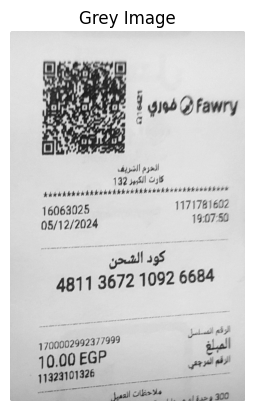

In [ ]:
receiptGrey = rgb2gray(reciept)
show_images([receiptGrey], ["Grey Image"])

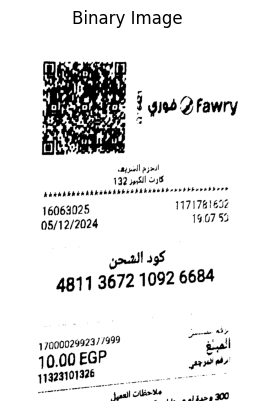

In [ ]:
receiptBinary = receiptGrey > threshold_otsu(receiptGrey)
show_images([receiptBinary], ["Binary Image"])

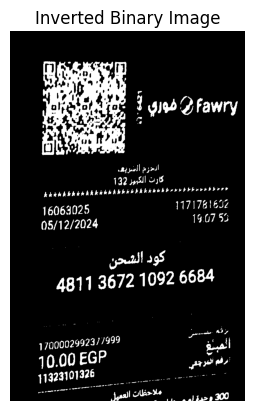

In [ ]:
receiptBinaryInverted = np.invert(receiptBinary)
show_images([receiptBinaryInverted], ["Inverted Binary Image"])

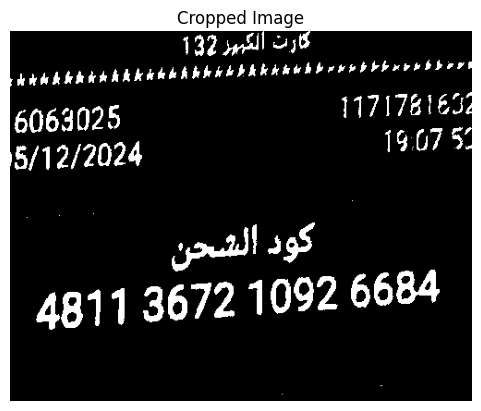

In [ ]:
receiptBinaryCropped = receiptBinaryInverted[400:800, 100:600]
show_images([receiptBinaryCropped], ["Cropped Image"])

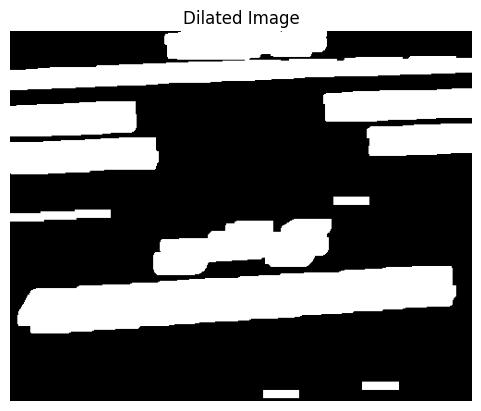

In [ ]:
binarydilated = binary_dilation(receiptBinaryCropped,np.ones((5,20)),iterations=2)
show_images([binarydilated], ["Dilated Image"])

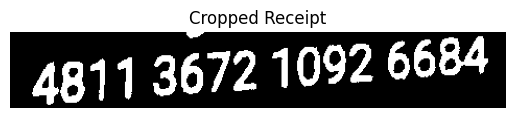

In [ ]:
#now crop the largest contour
contours = find_contours(binarydilated,0.8)
max_area = 0
max_contour = None
for contour in contours:
    if len(contour) > max_area:
        max_area = len(contour)
        max_contour = contour

min_x = int(np.min(max_contour[:,1]))
max_x = int(np.max(max_contour[:,1]))
min_y = int(np.min(max_contour[:,0]))
max_y = int(np.max(max_contour[:,0]))

cropped_receipt = receiptBinaryCropped[min_y:max_y,min_x:max_x]
show_images([cropped_receipt], ["Cropped Receipt"])

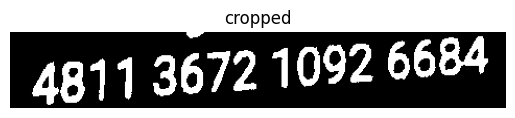

In [32]:
img = cropped_receipt
show_images([img], ["cropped"])

In [33]:
from scipy.ndimage import binary_erosion, binary_dilation, binary_opening, binary_closing

Number of contours found: 27
Number of contours after filtering: 15


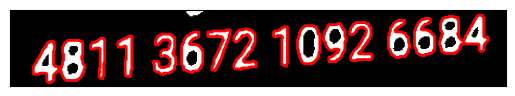

Current min_contour_size: 100
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 15


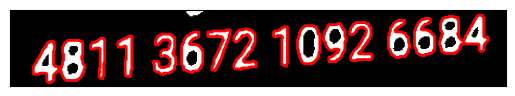

Current min_contour_size: 95
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 15


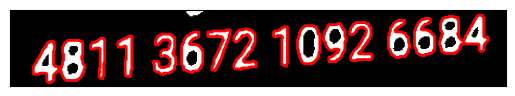

Current min_contour_size: 90
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 15


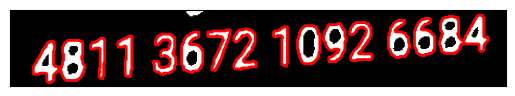

Current min_contour_size: 85
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 15


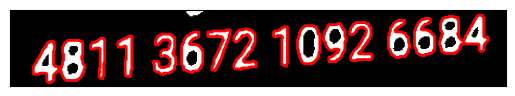

Current min_contour_size: 80
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 16


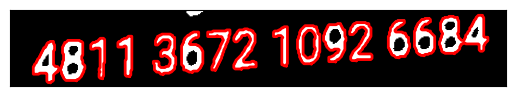

Current min_contour_size: 75
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 16


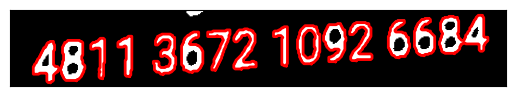

Current min_contour_size: 70
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 16


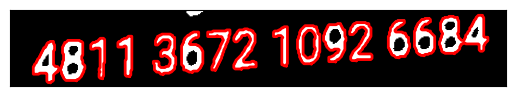

Current min_contour_size: 65
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 16


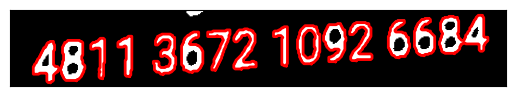

Current min_contour_size: 60
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 16


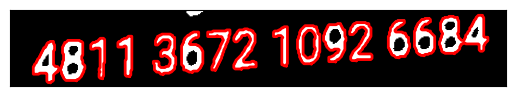

Current min_contour_size: 55
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 18


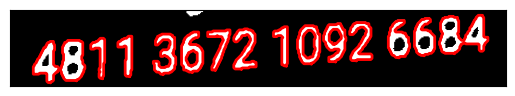

Current min_contour_size: 50
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 20


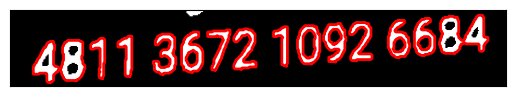

Current min_contour_size: 45
Number of letters: 15
Number of contours found: 27
Number of contours after filtering: 22


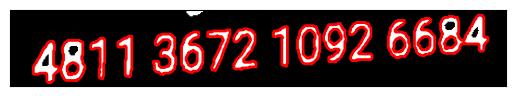

Current min_contour_size: 40
Number of letters: 15


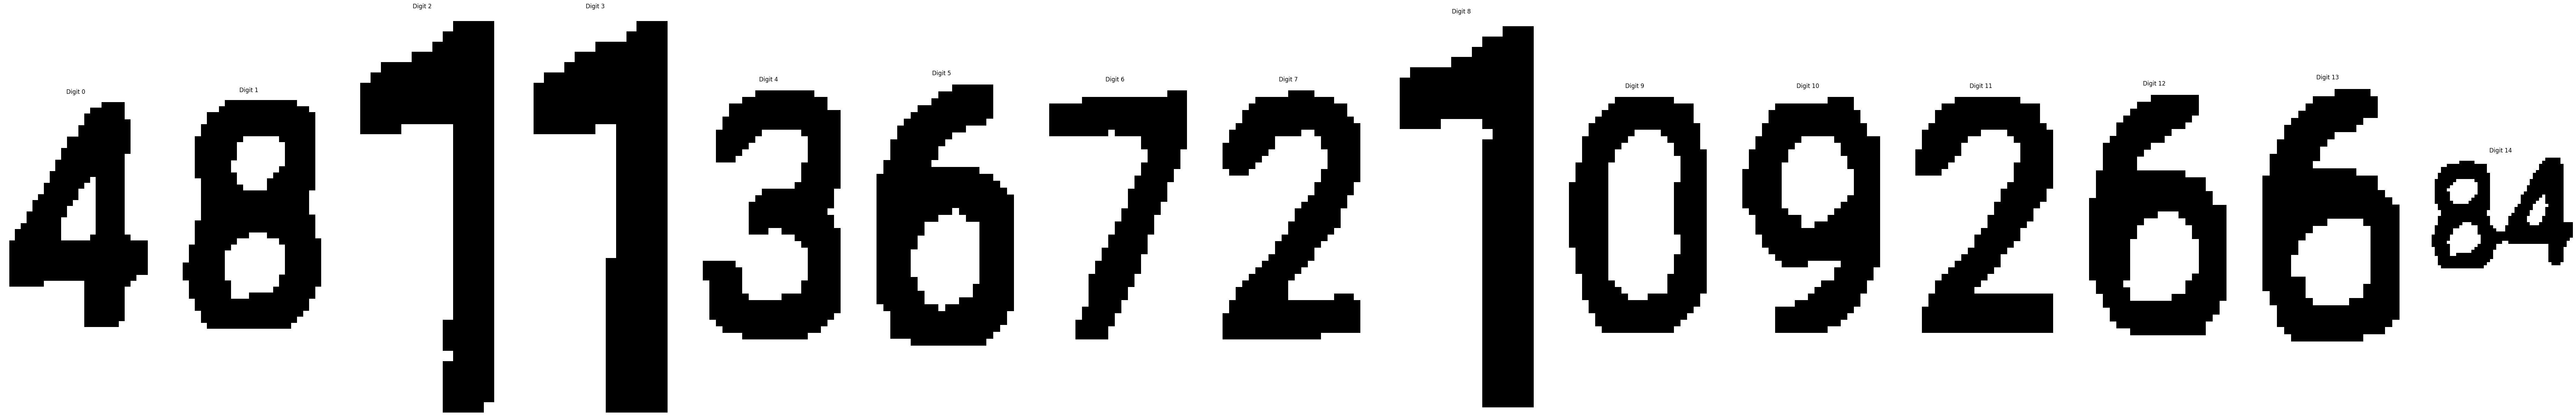

1
15


In [34]:
import cv2
import os
import numpy as np
import heapq
from skimage.measure import find_contours
import matplotlib.pyplot as plt


# Apply erosion
img = binary_opening(img, np.ones((2,2)), iterations=2)

def process_contours(img,min_contour_size = 100):
    global contours, queue, existing_regions, letters

    # Find contours of the digits
    contours = find_contours(img, 0.8)
    print("Number of contours found:", len(contours))

    # Keep only the big contours
    contours = [contour for contour in contours if contour.shape[0] > min_contour_size]
    print("Number of contours after filtering:", len(contours))

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    queue = []
    existing_regions = []  # To store existing bounding boxes

    # Function to check intersection between bounding boxes
    def intersects(new_box, existing_boxes):
        new_x1, new_y1, new_x2, new_y2 = new_box
        for box in existing_boxes:
            x1, y1, x2, y2 = box
            if not (new_x2 < x1 or new_x1 > x2 or new_y2 < y1 or new_y1 > y2):
                return True  # Intersection found
        return False

    # Extract bounding boxes for contours
    for contour in contours:
        maxY = contour[:, 0].max()
        maxX = contour[:, 1].max()
        minY = contour[:, 0].min()
        minX = contour[:, 1].min()

        
        
        new_box = (minX, minY, maxX, maxY)
        if not intersects(new_box, existing_regions):
            # Push regions to a heap for sorting by X-coordinate
            heapq.heappush(queue, (minX, img[int(minY):int(maxY), int(minX):int(maxX)]))
            existing_regions.append(new_box)

    # Extract individual digit images
    letters = []
    while len(queue) > 0:
        img_digit = heapq.heappop(queue)[1]  # Extract the digit region
        img_digit = img_digit.astype(np.uint8)
        img_digit = img_digit.max() - img_digit  # Invert colors if necessary
        letters.append(img_digit)  # Append the digit image to the list

# Adjust contour size dynamically to get at least 16 letters
min_contour_size = 100
while True:
    process_contours(img,min_contour_size)
    print("Current min_contour_size:", min_contour_size)
    print("Number of letters:", len(letters))
    if len(letters) >= 16 or min_contour_size <= 40:
        break
    min_contour_size -= 5  # Reduce the contour size threshold incrementally

# Show extracted digit images
show_images(letters, ["Digit " + str(i) for i in range(len(letters))])
print(letters[0].max())
print(len(letters))


In [35]:
for l in letters:
    print(l.shape)

(40, 25)
(39, 24)
(39, 14)
(39, 14)
(39, 22)
(39, 21)
(39, 22)
(39, 22)
(38, 14)
(37, 22)
(37, 22)
(37, 22)
(36, 21)
(36, 20)
(37, 47)


Number of images after splitting: 16


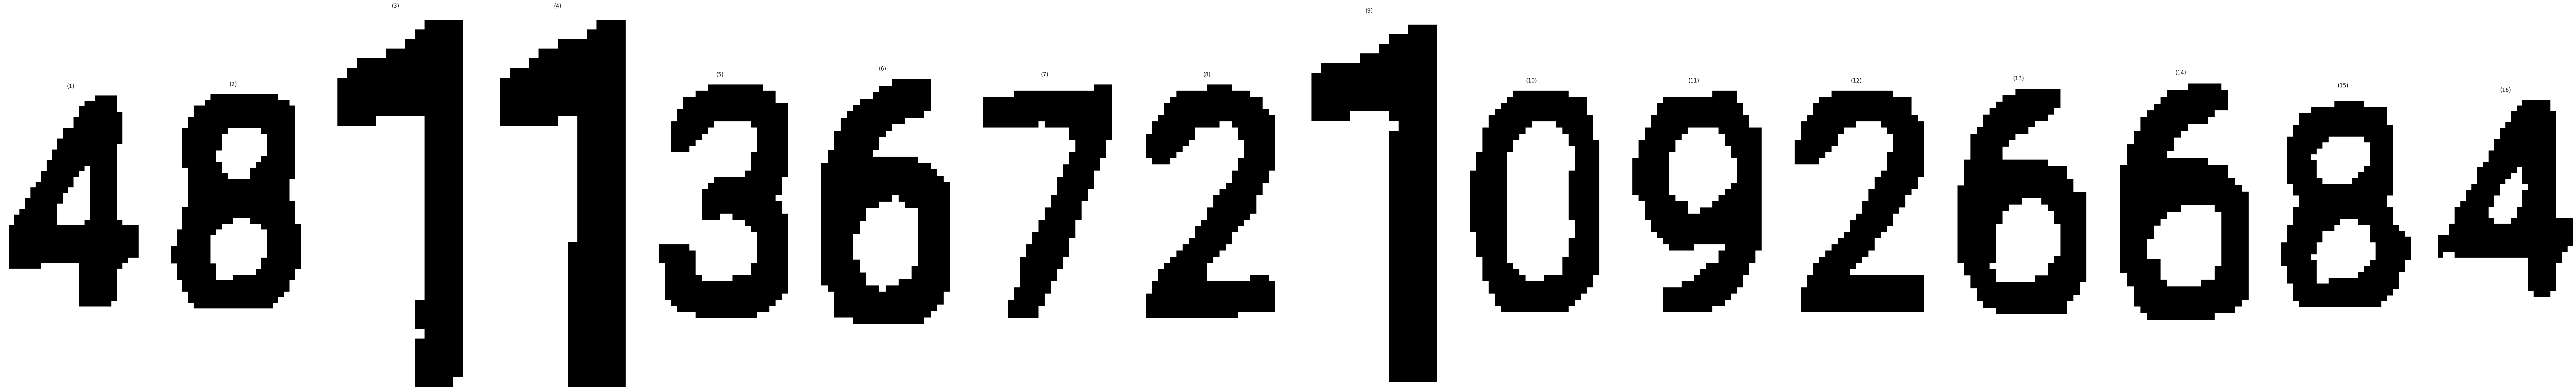

In [36]:
import cv2
import numpy as np

# Assume l is a list of image arrays
def split_large_image(images):
    # Step 1: Get column (width) sizes for all images
    col_sizes = [img.shape[1] for img in images]
    avg_col_size = sum(col_sizes) / len(col_sizes)

    # Step 2: Identify the image with double the column size
    for i, img in enumerate(images):
        if img.shape[1] >= 1.8 * avg_col_size:  # Flexibility with threshold (e.g., 1.8 instead of 2)
            # Step 3: Split the image vertically into two halves
            mid_col = img.shape[1] // 2
            left_half = img[:, :mid_col]  # Left part
            right_half = img[:, mid_col:]  # Right part

            # Step 4: Replace the large image with the two halves
            images[i] = left_half
            images.insert(i + 1, right_half)
            break  # Stop after splitting the first large image

    return images

# Example usage
# Assuming `l` is your list of image arrays loaded using cv2
# Example loading l = [cv2.imread("image1.png"), cv2.imread("image2.png"), ...]
for i in range(4):
    if len(letters) < 16:
        split_images = split_large_image(letters)
        print(f"Number of images after splitting: {len(split_images)}")
        show_images(letters)


In [ ]:
import cv2
import numpy as np
import os

def preprocess_image(img, dimensions):
    img_resized = cv2.resize(img, dimensions)
    
    # Convert RGBA to RGB if necessary
    if len(img_resized.shape) == 3 and img_resized.shape[2] == 4:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    #check if the image is already in grayscale
    if len(img_resized.shape) == 3:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_resized
    #show_images([img_gray], ["Gray Image"])

    #now make it binary
    img_binary = np.zeros(img_gray.shape)
    img_binary[img_gray > 0.9] = 255
    #img_binary *= 255
    img_binary = img_binary.astype(np.uint8)
    #show_images([img_binary], ["Binary Image"])
    print(img_gray.max())
    return img_binary

def save_and_preprocess_images(images, dimensions, output_folder):
    """
    Loops through an array of images, preprocesses them, and saves them to a file.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img in enumerate(images):
        # Preprocess image
        img_binary = preprocess_image(img, dimensions)

        # Save the binary image to a file
        output_path = os.path.join(output_folder, f"image_{i}.png")
        cv2.imwrite(output_path, img_binary)
        print(f"Saved: {output_path}")


# Simulated input images (replace with actual images)

output_dir = "output_images1"
dimensions = (185,386)  # Resize dimensions (width, height)

# Process images and save
save_and_preprocess_images(letters, dimensions, output_dir)

1
Saved: output_images1\image_0.png
1
Saved: output_images1\image_1.png
1
Saved: output_images1\image_2.png
1
Saved: output_images1\image_3.png
1
Saved: output_images1\image_4.png
1
Saved: output_images1\image_5.png
1
Saved: output_images1\image_6.png
1
Saved: output_images1\image_7.png
1
Saved: output_images1\image_8.png
1
Saved: output_images1\image_9.png
1
Saved: output_images1\image_10.png
1
Saved: output_images1\image_11.png
1
Saved: output_images1\image_12.png
1
Saved: output_images1\image_13.png
1
Saved: output_images1\image_14.png
1
Saved: output_images1\image_15.png


In [38]:
import cv2
import os
import numpy as np

# Template matching function
def match_template(image, templates_folder):
    best_match = None
    highest_corr = -1
    
    for digit in range(10):  # Loop through 0-9 folders
        digit_folder = os.path.join(templates_folder, str(digit))
        
        # Check if the digit folder exists
        if not os.path.exists(digit_folder):
            continue
        
        # Loop through all images inside the current digit folder
        for template_filename in os.listdir(digit_folder):
            template_path = os.path.join(digit_folder, template_filename)
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            
            # Ensure the template and image are the same size
            if image.shape == template_img.shape:
                # Perform template matching using normalized cross-correlation
                result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF_NORMED)
                corr_value = result[0][0]  # Single value since image size == template size

                # Track the best match
                if corr_value > highest_corr:
                    highest_corr = corr_value
                    best_match = str(digit)
    
    return best_match

# Loop through each letter image
predicted_digits = []
templates_folder = "templates2"  # Path to your templates2 folder
#show_images(letters, ["Letter Image"])

for letter_img in letters:
    #show_images([letter_img])  # Display the current letter

    # Preprocess the image (ensure it matches template dimensions)
    processed_img = preprocess_image(letter_img, (185,386))

    # Perform template matching
    predicted_digit = match_template(processed_img, templates_folder)
    predicted_digits.append(predicted_digit)

# Display the result
print("Predicted Digits:", "".join(predicted_digits))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Predicted Digits: 4811367210926684


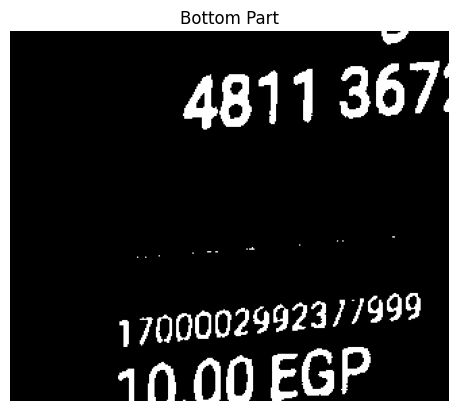

In [ ]:
bottomPart2 = receiptBinaryInverted[650:receiptBinaryInverted.shape[0]-100, 0:int(receiptBinaryInverted.shape[1]/2)].copy()
show_images([bottomPart2], ["Bottom Part"])

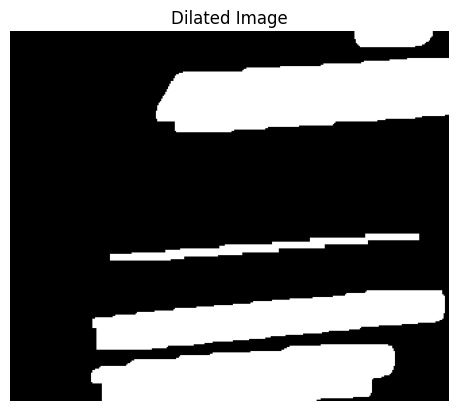

In [40]:
binarydilated2 = binary_dilation(bottomPart2,np.ones((3,20)),iterations=2)
show_images([binarydilated2], ["Dilated Image"])

In [41]:
def findDigitsInDilated(binarydilated, receiptBinaryCropped,numberOfContours):
    """Finds and shows the cropped areas of the largest 4 contours, sorted by vertical position."""
    # Find contours in the binary-dilated image
    contours = find_contours(binarydilated, 0.8)
    
    max_area = 0
    max_contour = None
    for contour in contours:
        if len(contour) > max_area:
            max_area = len(contour)
            max_contour = contour

    min_x = int(np.min(max_contour[:,1]))
    max_x = int(np.max(max_contour[:,1]))
    min_y = int(np.min(max_contour[:,0]))
    max_y = int(np.max(max_contour[:,0]))
    
    croppedreceippt2 = receiptBinaryCropped[min_y:max_y,min_x:max_x]
    return croppedreceippt2


In [42]:
croppedNumbers = findDigitsInDilated(binarydilated2,bottomPart2,4)

Number of contours found: 23
Number of contours after filtering: 10


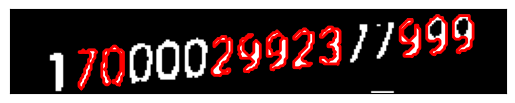

Current min_contour_size: 70
Number of letters: 10


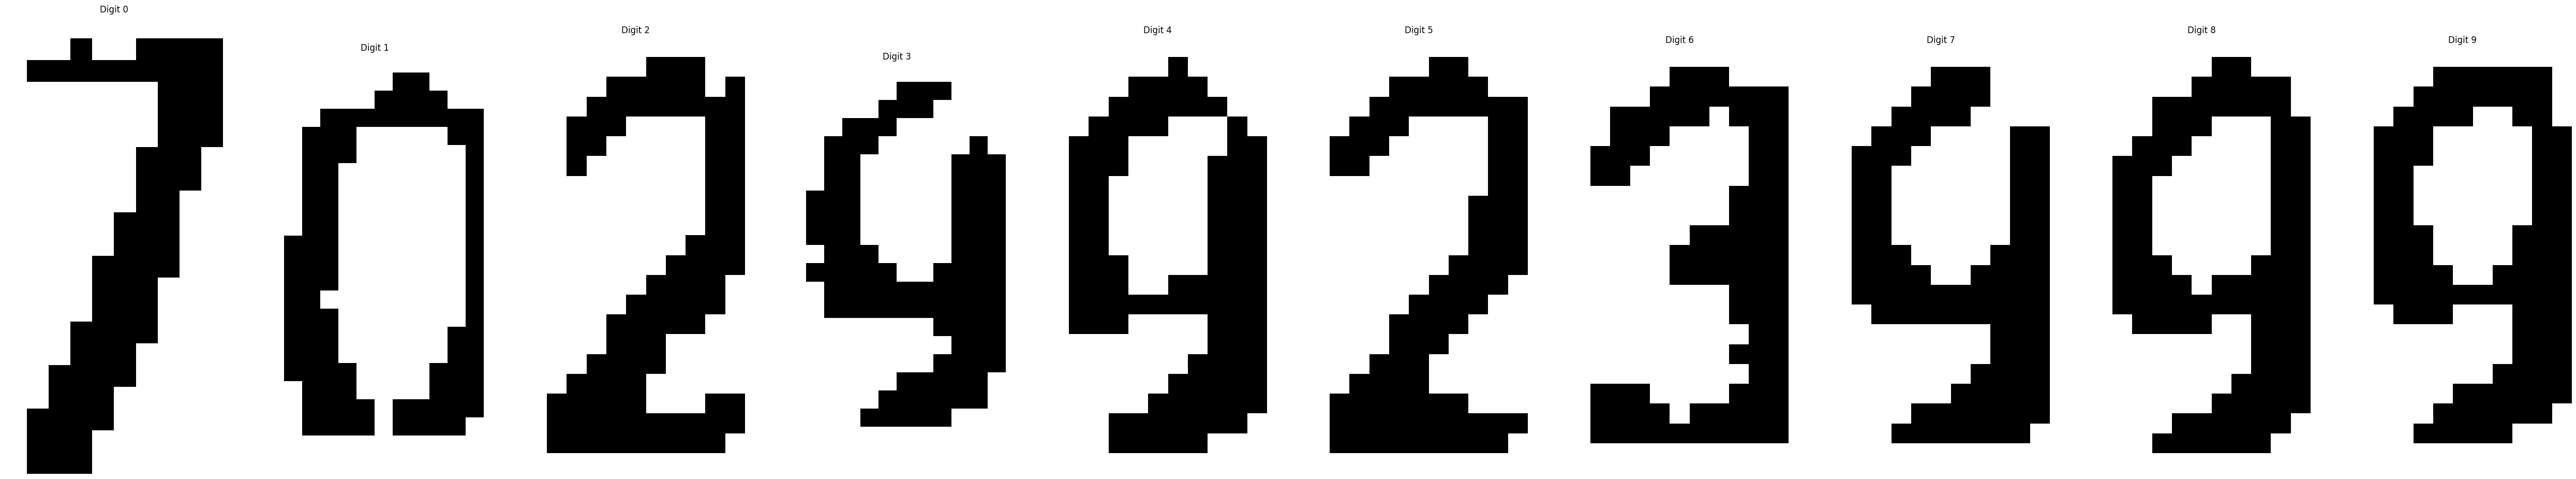

1
10


In [43]:
img = croppedNumbers

min_contour_size = 70
while True:
    img = croppedNumbers
    process_contours(img,min_contour_size)
    print("Current min_contour_size:", min_contour_size)
    print("Number of letters:", len(letters))
    if len(letters) >= 7 or min_contour_size <= 40:
        break
    min_contour_size -= 5  # Reduce the contour size threshold incrementally
# Show extracted digit images
show_images(letters, ["Digit " + str(i) for i in range(len(letters))])
print(letters[0].max())
print(len(letters))

In [44]:
output_dir = "output_images3"
dimensions = (185,386)  # Resize dimensions (width, height)

# Process images and save
save_and_preprocess_images(letters, dimensions, output_dir)


1
Saved: output_images3\image_0.png
1
Saved: output_images3\image_1.png
1
Saved: output_images3\image_2.png
1
Saved: output_images3\image_3.png
1
Saved: output_images3\image_4.png
1
Saved: output_images3\image_5.png
1
Saved: output_images3\image_6.png
1
Saved: output_images3\image_7.png
1
Saved: output_images3\image_8.png
1
Saved: output_images3\image_9.png


In [ ]:


# Template matching function
def match_template_with_symbols(image, templates_folder):
    best_match = None
    highest_corr = -1
    
    # Define folder names and corresponding symbols
    symbol_mapping = {
        "0": "0", "1": "1", "2": "2", "3": "3", "4": "4",
        "5": "5", "6": "6", "7": "7", "8": "8", "9": "9",
        "E": "E", "G": "G", "P": "P", "aa": "."
    }
    
    for folder_name, symbol in symbol_mapping.items():  # Loop through folders
        folder_path = os.path.join(templates_folder, folder_name)
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            continue
        
        # Loop through all images inside the current folder
        for template_filename in os.listdir(folder_path):
            template_path = os.path.join(folder_path, template_filename)
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            
            # Ensure the template and image are the same size
            if image.shape == template_img.shape:
                # Perform template matching using normalized cross-correlation
                result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF_NORMED)
                corr_value = result[0][0]  # Single value since image size == template size

                # Track the best match
                if corr_value > highest_corr:
                    highest_corr = corr_value
                    best_match = symbol  # Use the symbol for this folder
    
    return best_match

# Loop through each letter image
predictedPrice = []
templates_folder = "templates2"  # Path to your templates2 folder
letters = letters[:4]
for letter_img in letters:
    # Preprocess the image (ensure it matches template dimensions)
    processed_img = preprocess_image(letter_img, (185, 386))

    # Perform template matching
    predicted_symbol = match_template_with_symbols(processed_img, templates_folder)
    predictedPrice.append(predicted_symbol)
#The insert a dot before the last 2 digits
predictedPrice.insert(-2, ".")
#apped EGP to the end
predictedPrice.append("EGP")


# Display the result
print("Predicted Symbols:", "".join(predictedPrice))


1
1
1
1
Predicted Symbols: 70.29EGP


In [46]:
print("Predicted Price:", "".join(predictedPrice))
print("Predicted Digits:", "".join(predicted_digits))

Predicted Price: 70.29EGP
Predicted Digits: 4811367210926684
